In [2]:
from python_utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [6]:
import pandas as pd
dataset_ex_df = pd.read_csv('./MacroTrends_Data_Download_GS.csv', header=0, parse_dates=[0], date_parser=parser)

In [7]:
dataset_ex_df[['date', 'close']].head(10)


,date,close
0,1999-05-04,70.38
1,1999-05-05,69.13
2,1999-05-06,67.94
3,1999-05-07,74.13
4,1999-05-10,70.69
5,1999-05-11,70.63
6,1999-05-12,73.50
7,1999-05-13,74.25
8,1999-05-14,70.19
9,1999-05-17,68.63


In [8]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 4986 number of days in the dataset.


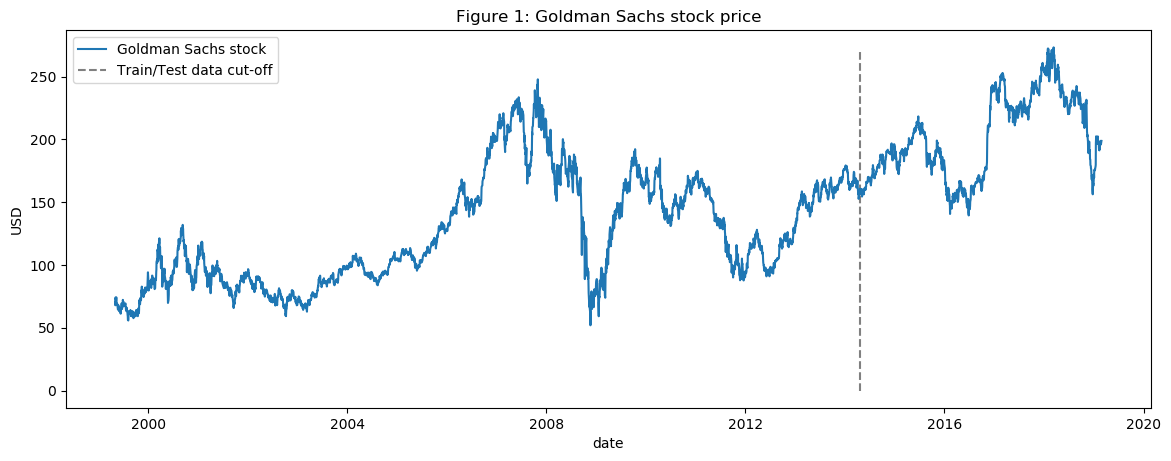

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['date'], dataset_ex_df['close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2014,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('date')
plt.ylabel('USD')
plt.title('Figure 1: Goldman Sachs stock price')
plt.legend()
plt.show()

In [10]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3490. Number of test days: 1496.


In [11]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['close']-1
    dataset['log_momentum'] = dataset['momentum'].pct_change()
    
    return dataset

In [12]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['close']])

In [13]:
dataset_TI_df.tail()

,close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
4981,198.60,195.544286,196.965238,193.526458,196.004209,2.477751,3.097964,203.161167,190.769309,198.405413,197.60,-0.000354
4982,196.36,196.262857,196.902381,193.736350,196.058946,2.322596,3.100587,203.103555,190.701207,197.041804,195.36,-0.011336
4983,196.00,196.478571,196.859524,193.904028,196.049878,2.145850,3.099288,203.058100,190.660947,196.347268,195.00,-0.001843
4984,198.65,197.044286,196.900000,194.255582,196.449897,2.194315,2.993316,202.886633,190.913367,197.882423,197.65,0.013590
4985,198.90,197.954286,196.812381,194.599613,196.826836,2.227223,2.955263,202.722907,190.901855,198.560808,197.90,0.001265


In [14]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


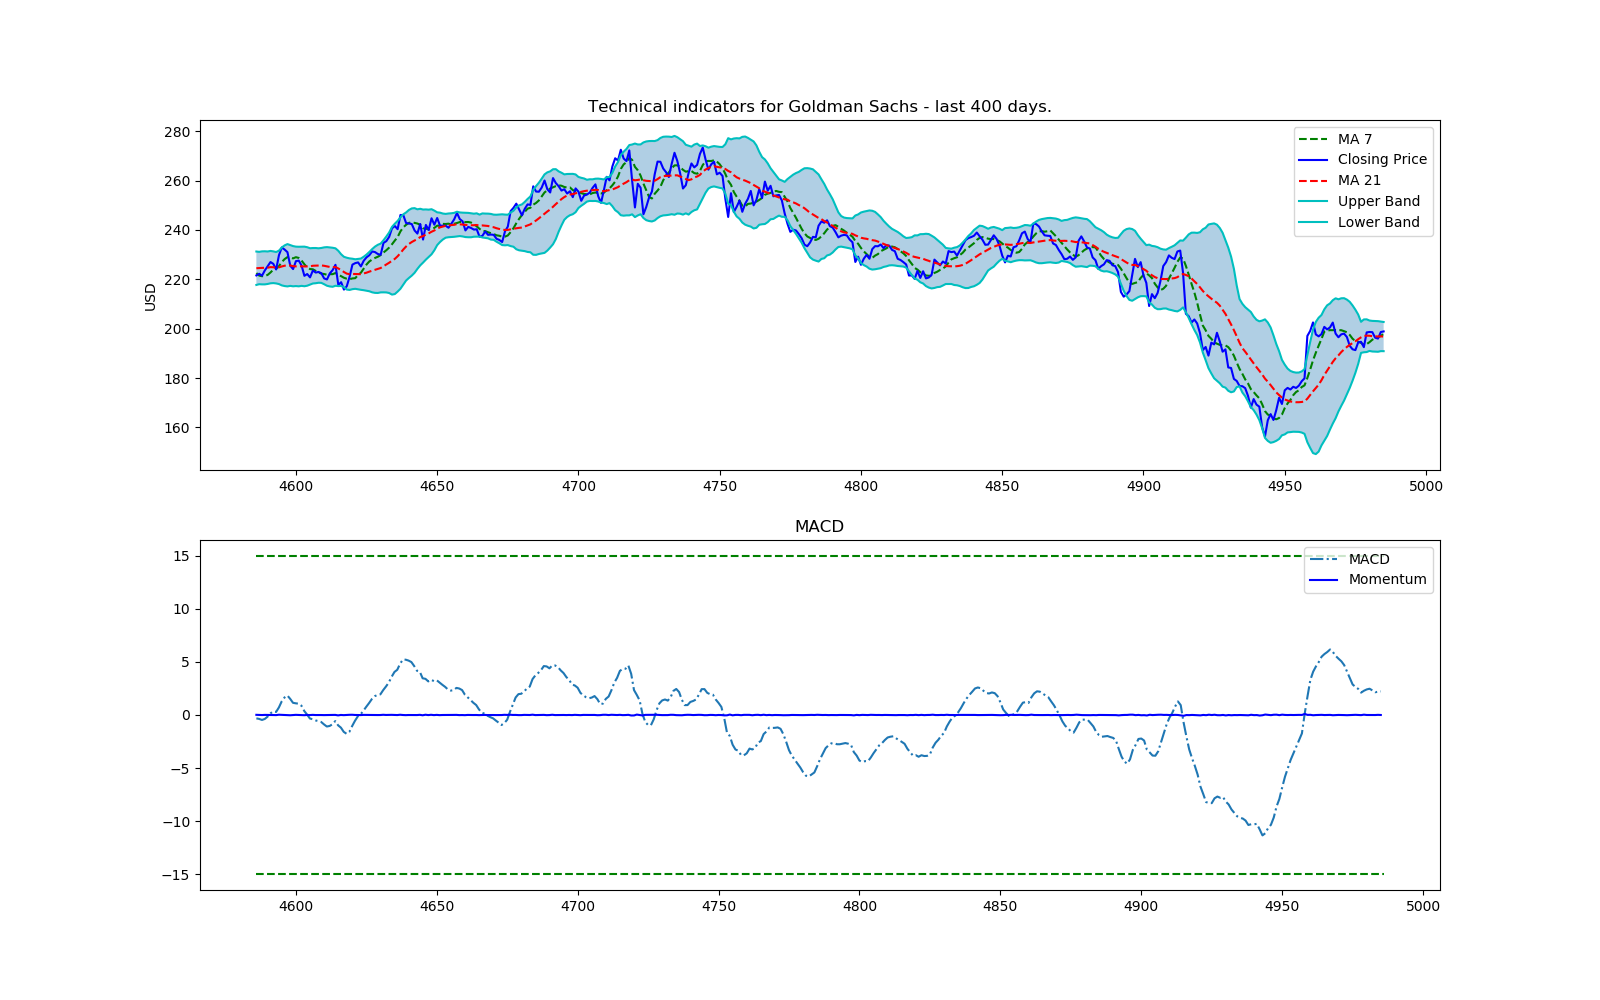

In [15]:
%matplotlib notebook
plot_technical_indicators(dataset_TI_df, 400)

In [16]:
data_FT = dataset_ex_df[['date', 'close']]

In [17]:
close_fft = np.fft.fft(np.asarray(data_FT['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

<IPython.core.display.Javascript object>


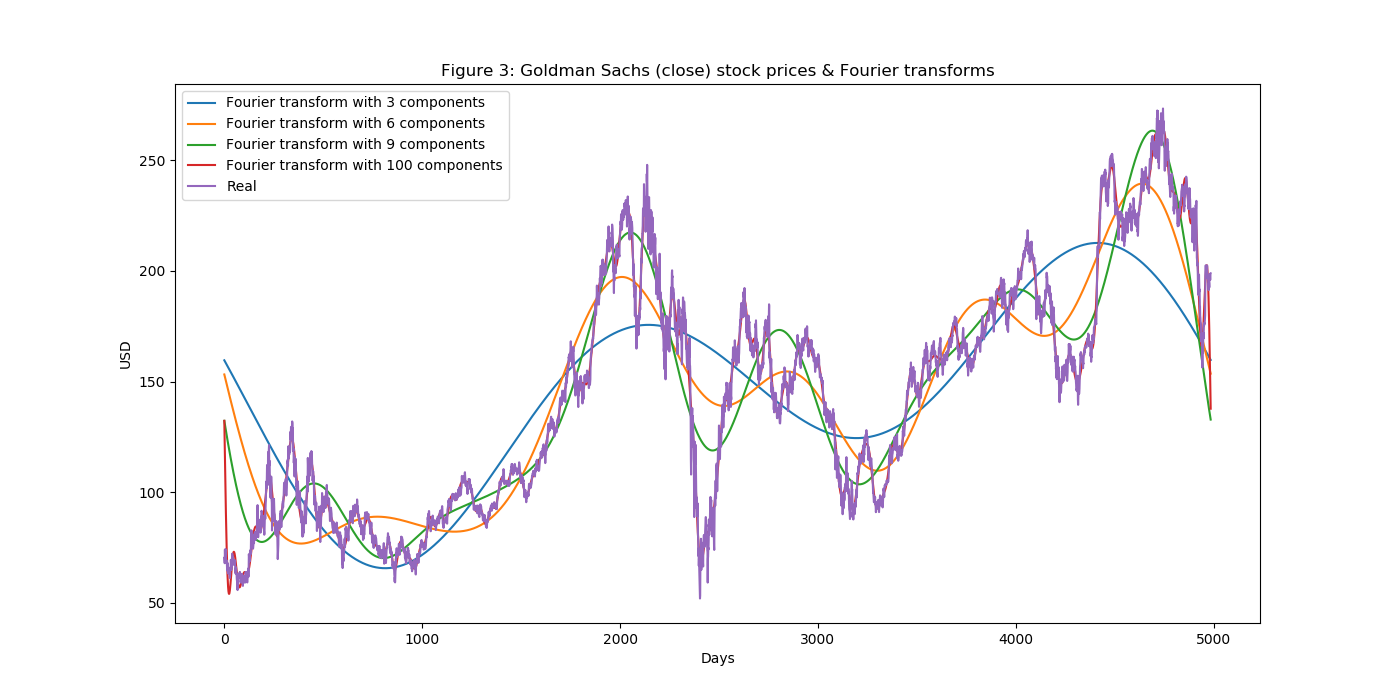

In [18]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

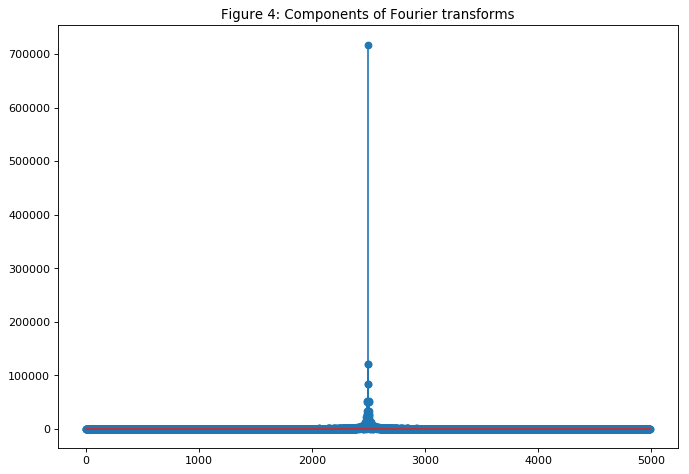

In [37]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 4985
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12503.481
Method:                       css-mle   S.D. of innovations              2.972
Date:                Fri, 01 Mar 2019   AIC                          25020.962
Time:                        00:43:40   BIC                          25066.561
Sample:                             1   HQIC                         25036.946
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0258      0.038      0.683      0.495      -0.048       0.100
ar.L1.D.close    -0.0419      0.014     -2.960      0.003      -0.070      -0.014
ar.L2.D.close    -0.0184      0.014     

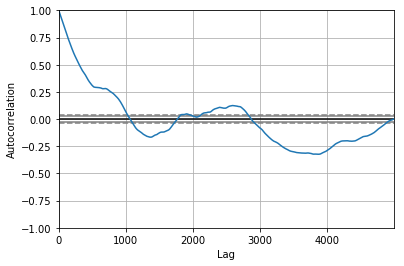

<Figure size 800x560 with 0 Axes>

In [23]:
%matplotlib inline
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [24]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [25]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 7.329


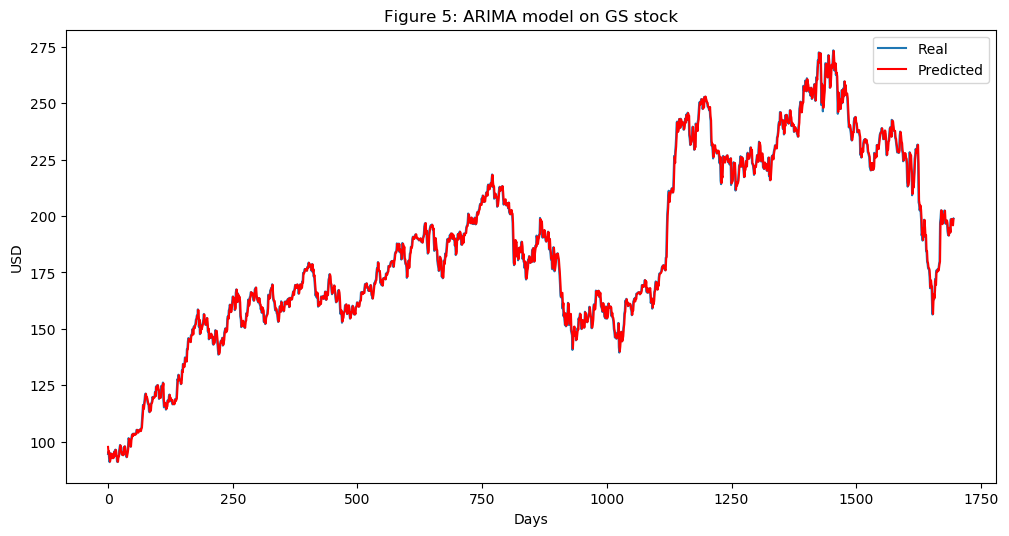

In [26]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [27]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

NameError: name 'dataset_total_df' is not defined

In [30]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [31]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [32]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [33]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [34]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

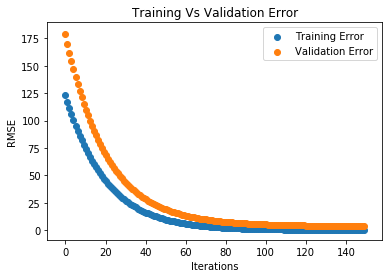

In [35]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

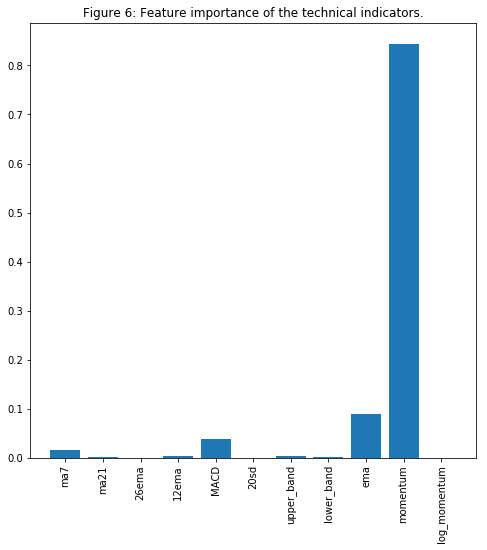

In [36]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()